<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/EDAForVolve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background
The Volve field was operated by Equinor in the Norwegian North Sea between 2008—2016. Located 200 kilometres west of Stavanger (Norway) at the southern end of the Norwegian sector, was decommissioned in September 2016 after 8.5 years in operation. Equinor operated it more than twice as long as originally planned. The development was based on production from the Mærsk Inspirer jack-up rig, with Navion Saga used as a storage ship to hold crude oil before export. Gas was piped to the Sleipner A platform for final processing and export. The Volve field reached a recovery rate of 54% and in March 2016 when it was decided to shut down its production permanently.

In [30]:
!pip install lasio
!pip install md_toc

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

In [32]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git

fatal: destination path 'Volve-Well-Log-Prediction' already exists and is not an empty directory.




### Data

Wireline-log files (.LAS) of five wells:

1. Log 1: 15_9-F-11A
2. Log 2: 15_9-F-11B
3. Log 3: 15_9-F-1A
4. Log 4: 15_9-F-1B
5. Log 5: 15_9-F-1C

The .LAS files contain the following feature columns:

| Name | Unit | Description | Read More |
|------|------|-------------|----------|
| Depth | [m] | Below Surface | |
| NPHI | [vol/vol] | Neutron Porosity (not calibrated in basic physical units) | [Reference](#) |
| RHOB | [g/cm3] | Bulk Density | [Reference](#) |
| GR | [API] | Gamma Ray radioactive decay (aka shalyness log) | [Reference](#) |
| RT | [ohm*m] | True Resistivity | [Reference](#) |
| PEF | [barns/electron] | PhotoElectric absorption Factor | [Reference](#) |
| CALI | [inches] | Caliper, Borehole Diameter | [Reference](#) |
| DT | [μs/ft] | Delta Time, Sonic Log, P-wave, interval transit time | [Reference](#) |





In [33]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

DEPTH  ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO  DT  DTS  \
0  188.5       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
1  188.6       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
2  188.7       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
3  188.8       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
4  188.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   

   ...  PEF  RACEHM  RACELM  RD  RHOB  RM  ROP  RPCEHM  RPCELM  RT  
0  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
1  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
2  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
3  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
4  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  

[5 rows x 22 columns]

### Problem

Wells 15/9-F-11B (log 2) and 15/9-F-1C (log 5) lack the DT Sonic Log feature.

### Goal

Predict Sonic Log (DT) feature in these two wells.

In [34]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list

# Helper function for repeated plotting

def makeplot(df,suptitle_str="pass a suptitle"):

  # Lists of used columns and colors
  columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
  colors = ['red', 'darkblue', 'black', 'green', 'purple', 'brown', 'turquoise']

  # determine how many columns are available in the log (some miss 'DT')
  col_counter = 0
  for i in df.columns:
    if i in columns:
      col_counter+=1

  # Create the subplots
  fig, ax = plt.subplots(nrows=1, ncols=col_counter, figsize=(col_counter*2,10))
  fig.suptitle(suptitle_str, size=20, y=1.05)

  # Looping each log to display in the subplots
  for i in range(col_counter):
    if i == 3:
      # semilog plot for resistivity ('RT')
      ax[i].semilogx(df[columns[i]], df['DEPTH'], color=colors[i])
    else:
      # all other -> normal plot
      ax[i].plot(df[columns[i]], df['DEPTH'], color=colors[i])

    ax[i].set_title(columns[i])
    ax[i].grid(True)
    ax[i].invert_yaxis()

  plt.tight_layout() #avoids label overlap
  plt.show()



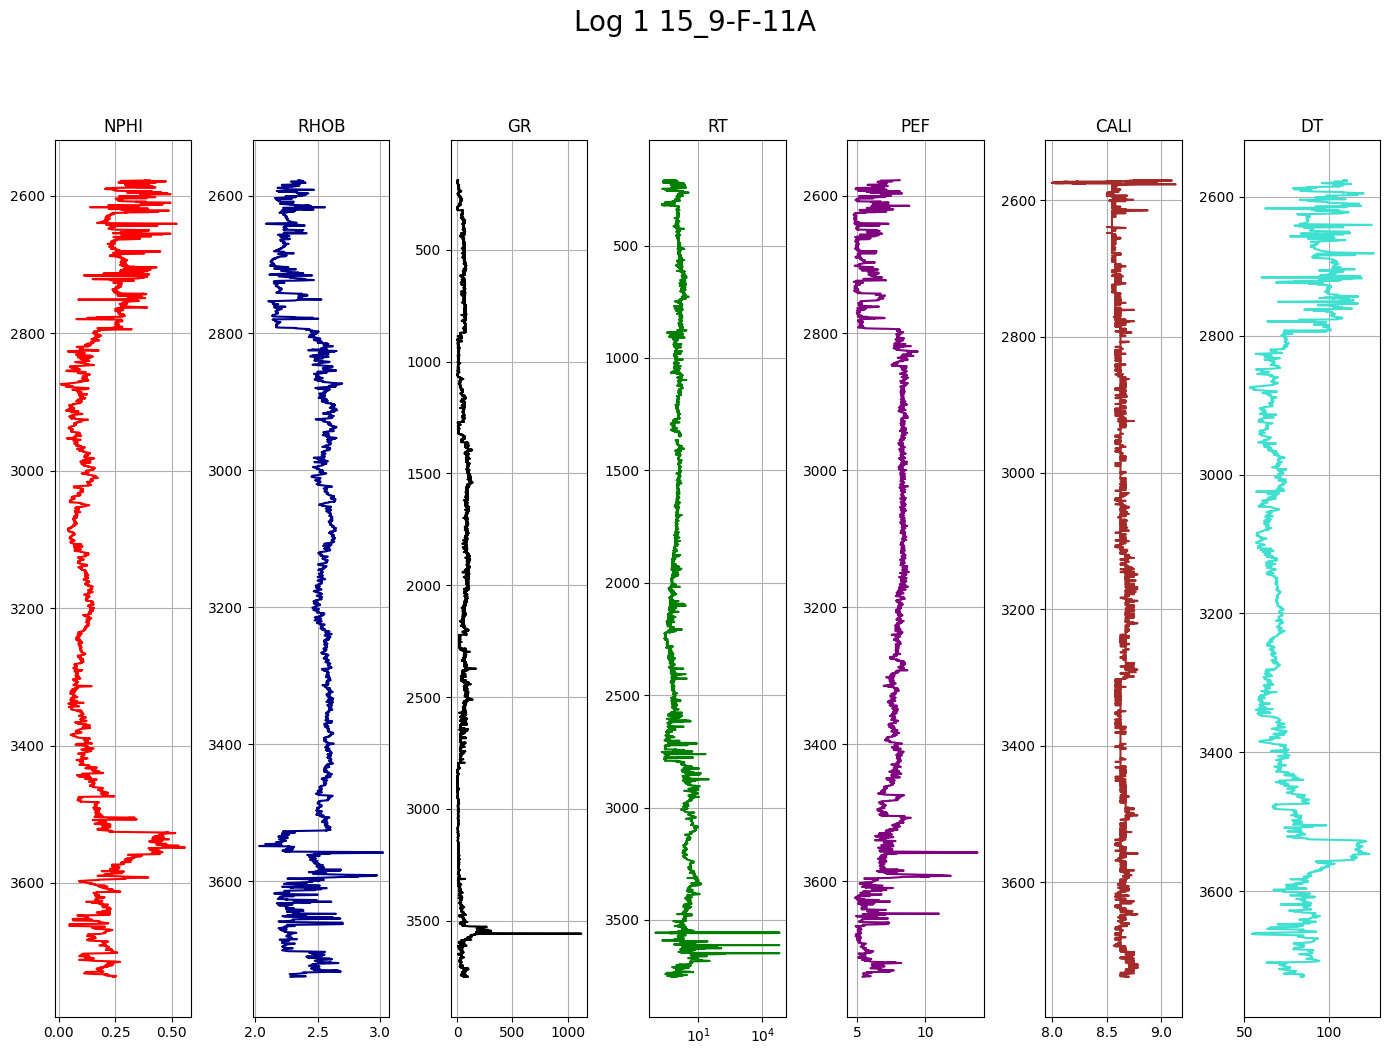

In [35]:
makeplot(log1,"Log 1 15_9-F-11A")

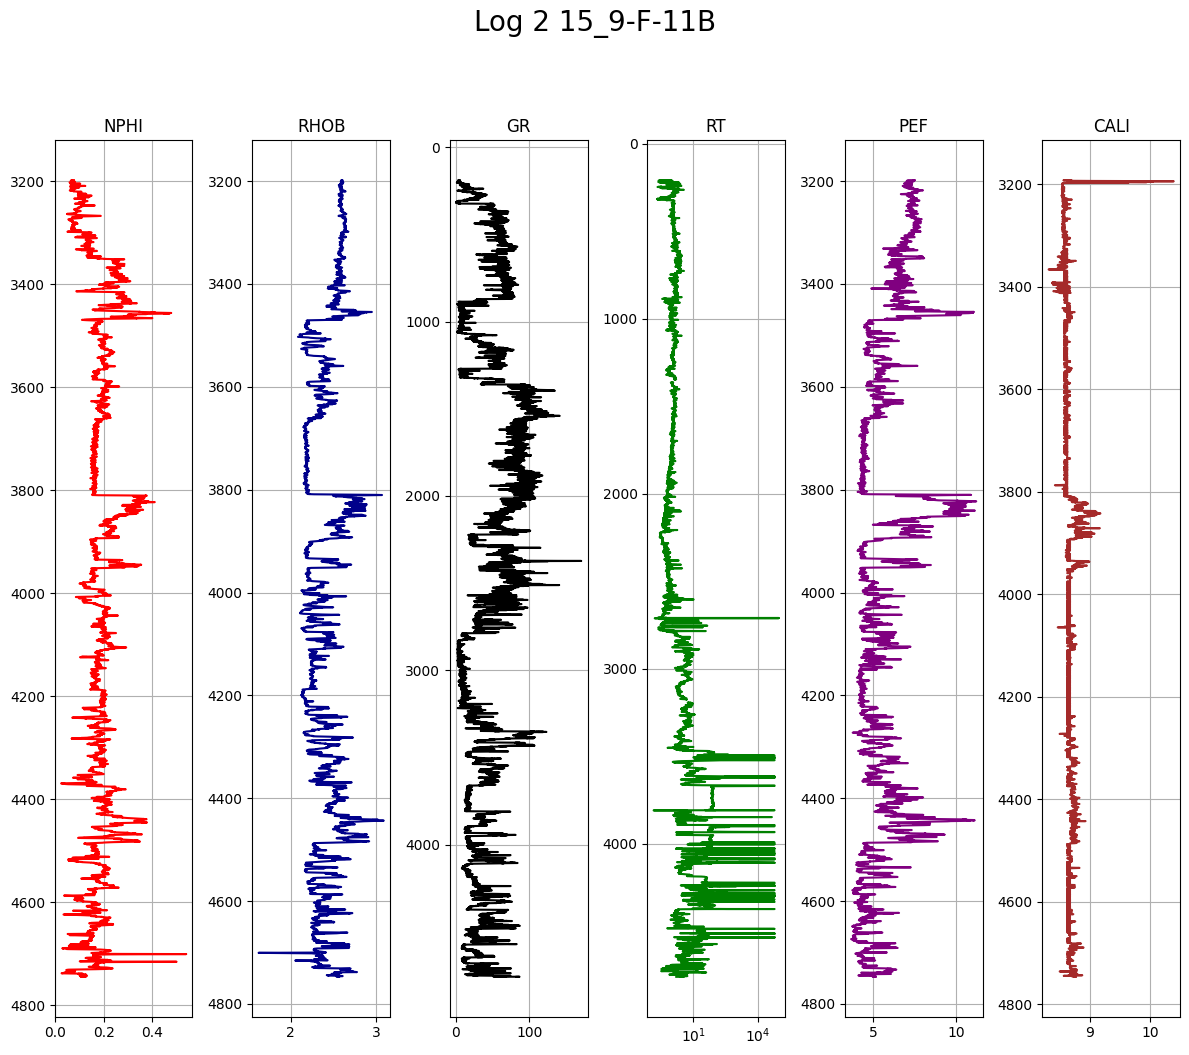

In [36]:
makeplot(log2, "Log 2 15_9-F-11B")


### Data Preparation

- **Train Test Split**:
  - Train on logs 1, 3, and 4.
  - Test (validation) on logs 2 and 5.

- **NaN Values**:
  - There are many NaN values in the logs.
  - The plots above only display the samples that are non-NaN and thus can be used to gauge where they need to be clipped.
  - NaN values are primarily present on top and bottom of each log before readings start.
  - The logs get clipped around the following depths:
    - Log 1: 2,600 - 3,720 m
    - Log 2: 3,200 - 4,740 m
    - Log 3: 2,620 - 3,640 m
    - Log 4: 3,100 - 3,400 m
    - Log 5: 3,100 - 4,050 m

- **Feature Selection**:
  - The logs contain many more features than needed.
  - The correct features will get selected for further use, while the rest gets discarded.



In [37]:
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1

DEPTH   NPHI   RHOB      GR     RT    PEF   CALI       DT
24115  2600.0  0.371  2.356  82.748  1.323  7.126  8.648  104.605
24116  2600.1  0.341  2.338  79.399  1.196  6.654  8.578  103.827
24117  2600.2  0.308  2.315  74.248  1.171  6.105  8.578  102.740
24118  2600.3  0.283  2.291  68.542  1.142  5.613  8.547  100.943
24119  2600.4  0.272  2.269  60.314  1.107  5.281  8.523   98.473
...       ...    ...    ...     ...    ...    ...    ...      ...
35311  3719.6  0.236  2.617  70.191  1.627  7.438  8.703   84.800
35312  3719.7  0.238  2.595  75.393  1.513  7.258  8.750   85.013
35313  3719.8  0.236  2.571  82.648  1.420  7.076  8.766   85.054
35314  3719.9  0.217  2.544  89.157  1.349  6.956  8.781   84.928
35315  3720.0  0.226  2.520  90.898  1.301  6.920  8.781   84.784

[11201 rows x 8 columns]

In [38]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train

NPHI    RHOB       GR      RT     PEF    CALI        DT        WELL  \
24115  0.3710  2.3560  82.7480  1.3230  7.1260  8.6480  104.6050  15_9-F-11A   
24116  0.3410  2.3380  79.3990  1.1960  6.6540  8.5780  103.8270  15_9-F-11A   
24117  0.3080  2.3150  74.2480  1.1710  6.1050  8.5780  102.7400  15_9-F-11A   
24118  0.2830  2.2910  68.5420  1.1420  5.6130  8.5470  100.9430  15_9-F-11A   
24119  0.2720  2.2690  60.3140  1.1070  5.2810  8.5230   98.4730  15_9-F-11A   
...       ...     ...      ...     ...     ...     ...       ...         ...   
32537  0.1861  2.4571  60.4392  1.2337  5.9894  8.7227   75.3947   15_9-F-1B   
32538  0.1840  2.4596  61.8452  1.2452  6.0960  8.6976   75.3404   15_9-F-1B   
32539  0.1798  2.4637  61.1386  1.2960  6.1628  8.6976   75.3298   15_9-F-1B   
32540  0.1780  2.4714  59.3751  1.4060  6.1520  8.6976   75.3541   15_9-F-1B   
32541  0.1760  2.4809  58.3742  1.4529  6.1061  8.6978   75.4476   15_9-F-1B   

        DEPTH  
24115  2600.0  
24116  2600.1  
24117  2600.2  
24118  2600.3  
24119  2600.4  
...       ...  
32537  3399.6  
32538  3399.7  
32539  3399.8  
32540  3399.9  
32541  3400.0  

[24403 rows x 9 columns]

In [39]:
pred

NPHI    RHOB        GR      RT     PEF    CALI        WELL   DEPTH
30115  0.0750  2.6050    9.3480  8.3310  7.4510  8.5470  15_9-F-11B  3200.0
30116  0.0770  2.6020    9.3620  8.2890  7.4640  8.5470  15_9-F-11B  3200.1
30117  0.0780  2.5990    9.5450  8.2470  7.4050  8.5470  15_9-F-11B  3200.2
30118  0.0790  2.5940   11.1530  8.2060  7.2920  8.5470  15_9-F-11B  3200.3
30119  0.0780  2.5890   12.5920  8.1650  7.1670  8.5470  15_9-F-11B  3200.4
...       ...     ...       ...     ...     ...     ...         ...     ...
39037  0.3107  2.4184  106.7613  2.6950  6.2332  8.5569   15_9-F-1C  4049.6
39038  0.2997  2.4186  109.0336  2.6197  6.2539  8.5569   15_9-F-1C  4049.7
39039  0.2930  2.4232  106.0935  2.5948  6.2883  8.5570   15_9-F-1C  4049.8
39040  0.2892  2.4285  105.4931  2.6344  6.3400  8.6056   15_9-F-1C  4049.9
39041  0.2956  2.4309  109.8965  2.6459  6.3998  8.5569   15_9-F-1C  4050.0

[24902 rows x 8 columns]

## Exploratory Data Analysis

### Pair-plot of the Train Data

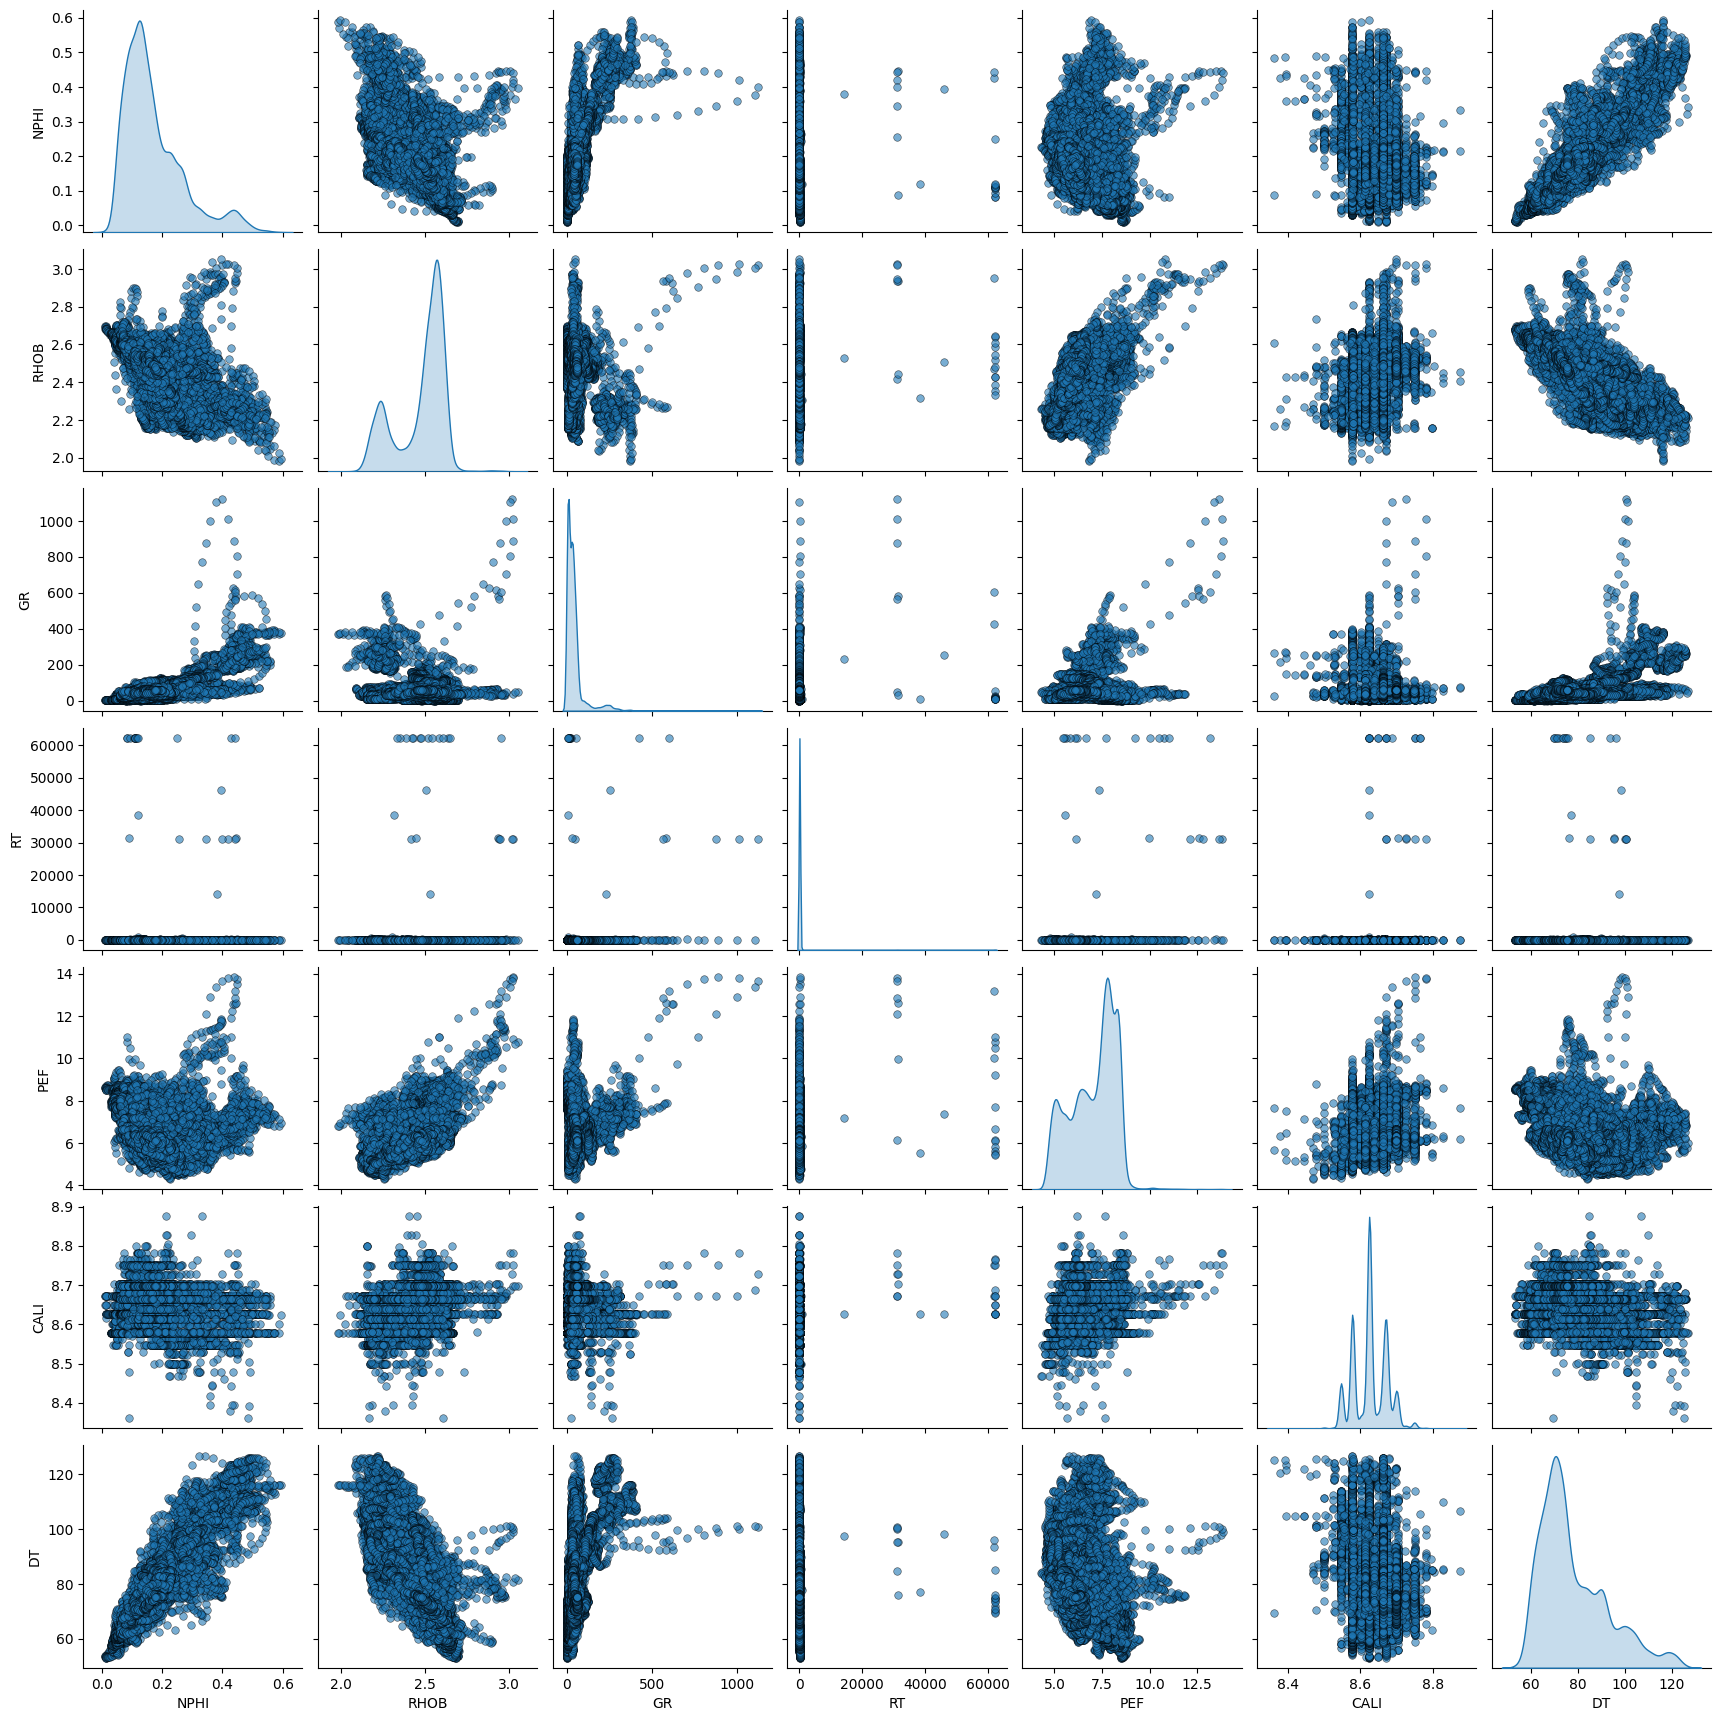

In [40]:
train_features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

sns.pairplot(train, vars=train_features, diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

### Spearman’s Correlation Heatmap

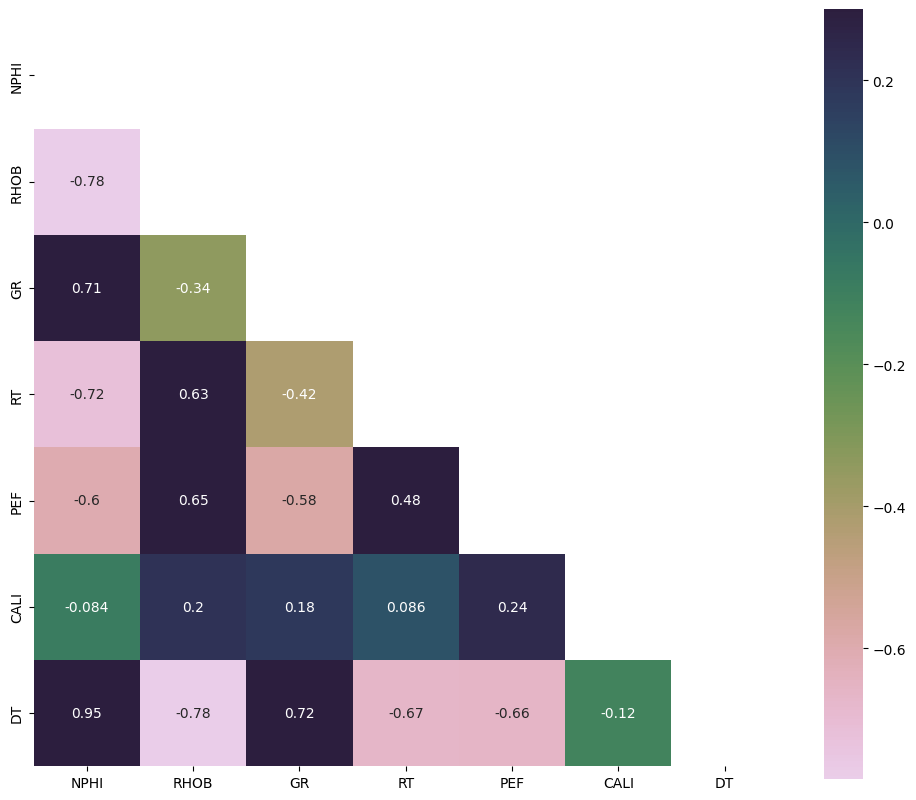

In [41]:
train_only_features = train[train_features]

# Generate a mask for the upper triangle
mask = np.zeros_like(train_only_features.corr(method = 'spearman') , dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Custom colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,10))
sns.heatmap(train_only_features.corr(method = 'spearman'), annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True)

plt.show()

## Transformation of the Train Data

Normalize/transform the dataset:

* Log transform the RT log

* Use power transform with Yeo-Johnson method (except ‘WELL’ and ‘DEPTH’)

In [42]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

In [43]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans

NPHI      RHOB        GR        RT       PEF      CALI        DT  \
0      1.702168 -0.920748   1.13065 -0.631876  0.031083  0.450019   1.58838   
1      1.573404 -1.020621  1.092435 -0.736154 -0.373325 -1.070848  1.562349   
2      1.407108 -1.142493  1.030314  -0.75808  -0.81989 -1.070848  1.525055   
3      1.260691 -1.263078  0.956135 -0.784153 -1.197992 -1.753641  1.460934   
4      1.189869 -1.367969  0.837247 -0.816586 -1.441155 -2.286221  1.367432   
...         ...       ...       ...       ...       ...       ...       ...   
24398  0.462363 -0.279351  0.839177 -0.704005 -0.910619  2.041708  0.047941   
24399  0.439808 -0.261621  0.860577 -0.694407 -0.826995  1.510434  0.043466   
24400  0.393869 -0.232335  0.849885  -0.65312 -0.774093  1.510434  0.042591   
24401  0.373838 -0.176628   0.82264 -0.569367 -0.782672  1.510434  0.044596   
24402  0.351335 -0.106609  0.806807 -0.535769 -0.819021  1.514682  0.052292   

             WELL   DEPTH  
0      15_9-F-11A  2600.0  
1      15_9-F-11A  2600.1  
2      15_9-F-11A  2600.2  
3      15_9-F-11A  2600.3  
4      15_9-F-11A  2600.4  
...           ...     ...  
24398   15_9-F-1B  3399.6  
24399   15_9-F-1B  3399.7  
24400   15_9-F-1B  3399.8  
24401   15_9-F-1B  3399.9  
24402   15_9-F-1B  3400.0  

[24403 rows x 9 columns]

### Pair-Plot (after transformation)

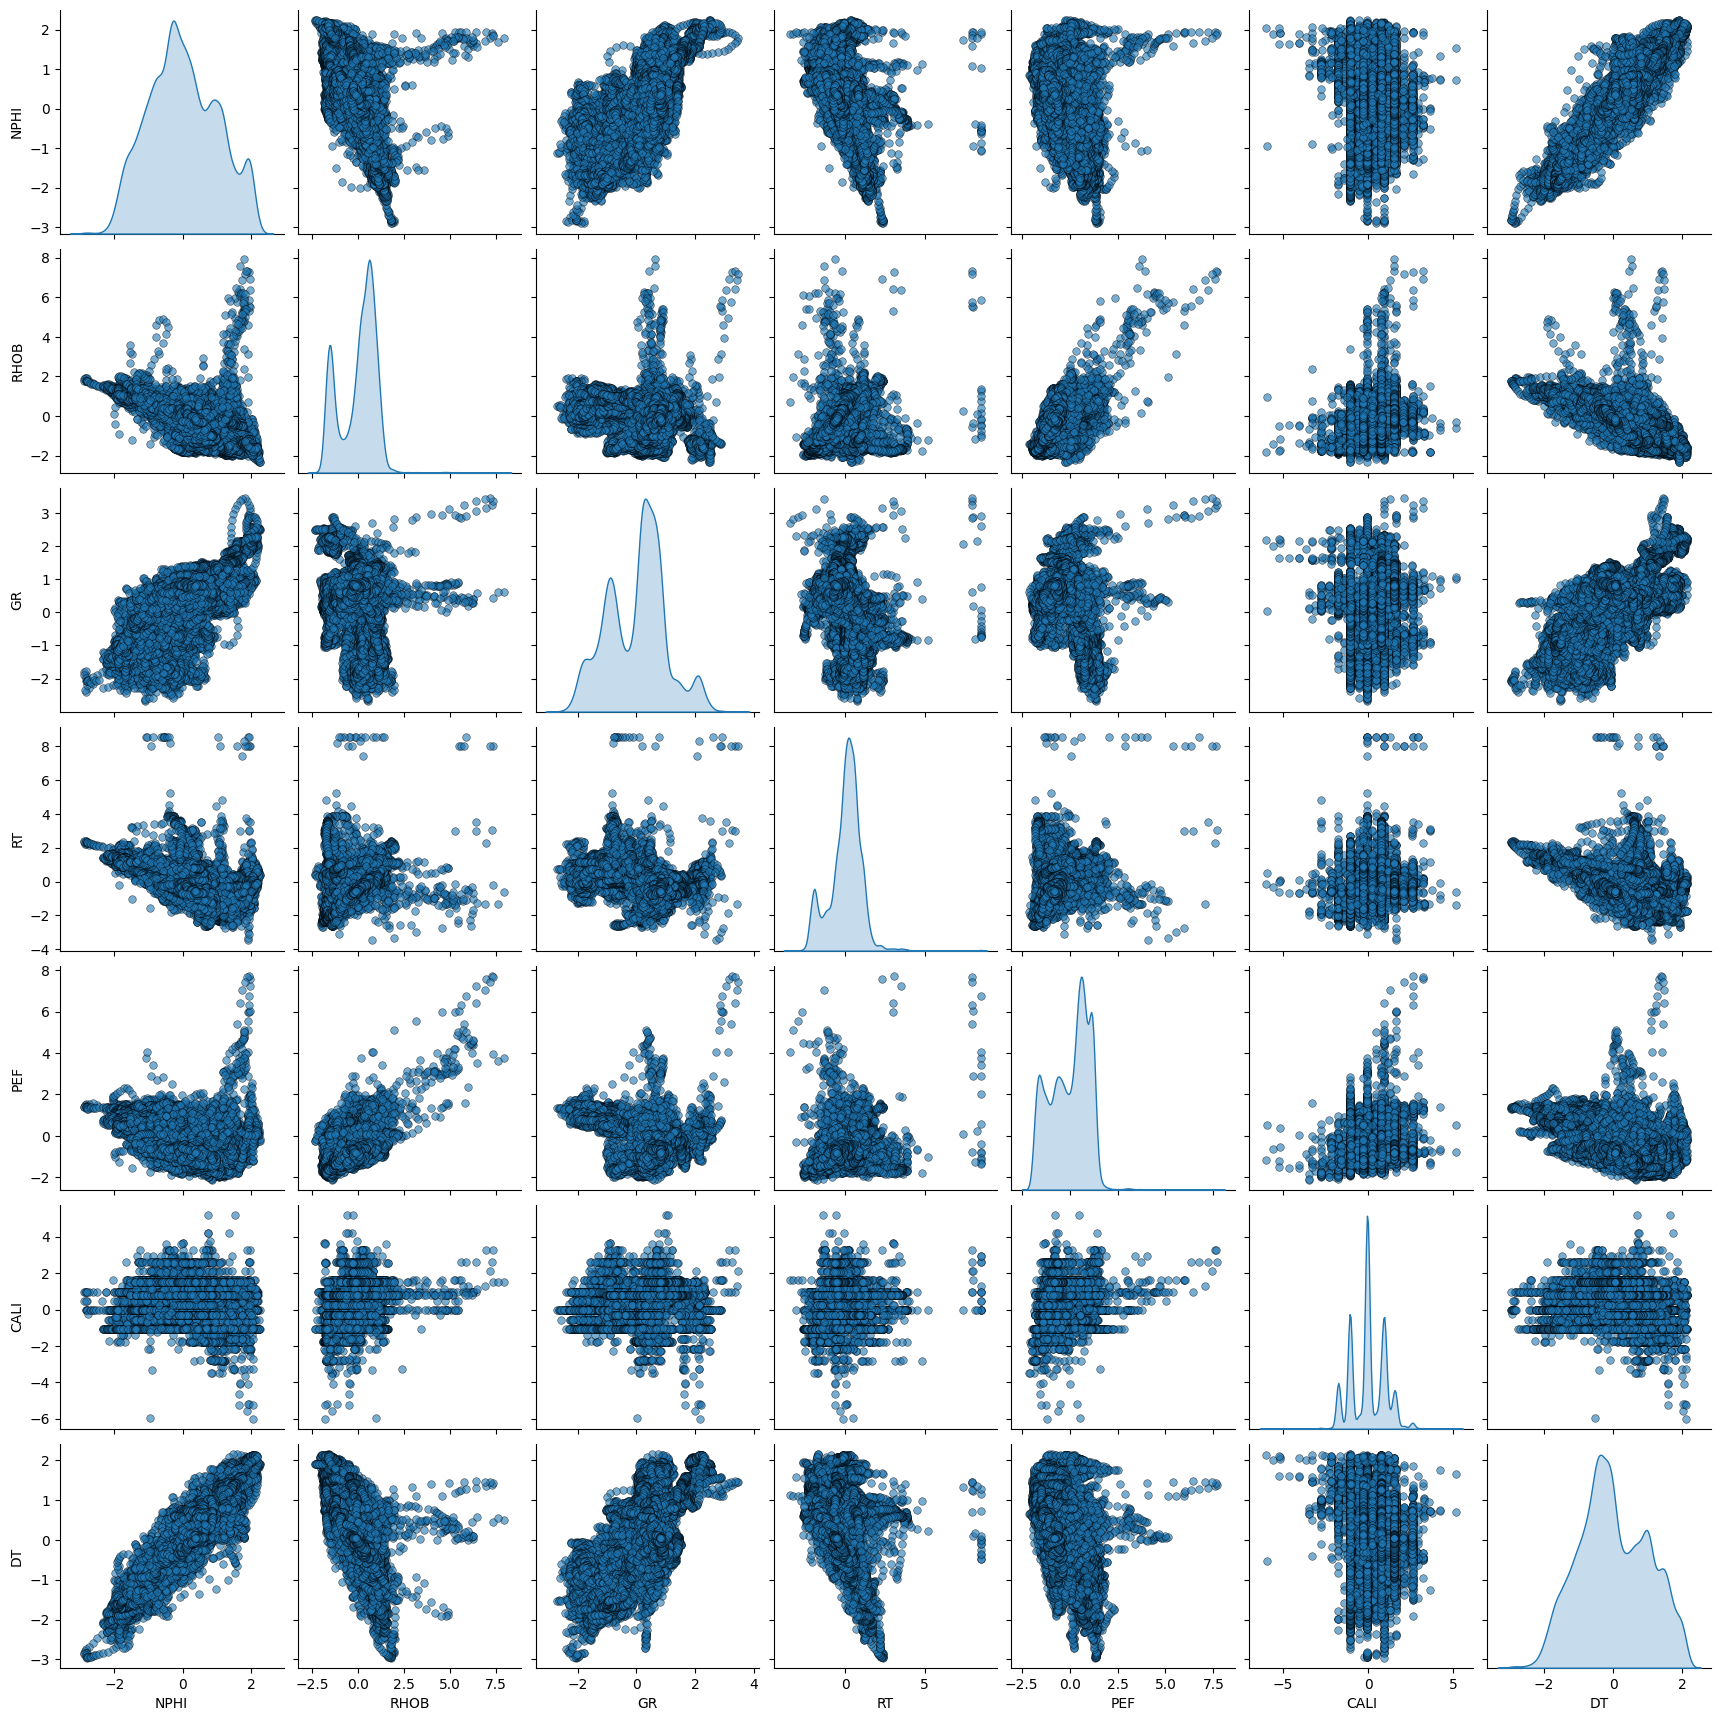

In [44]:
sns.pairplot(train_trans, vars=feature_target, diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

### Removing Outliers

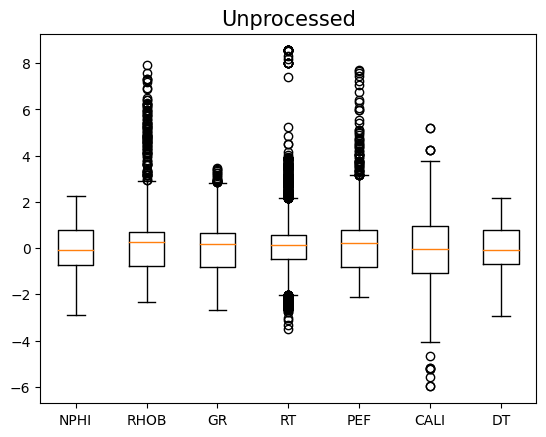

n samples unprocessed: 24403


In [45]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

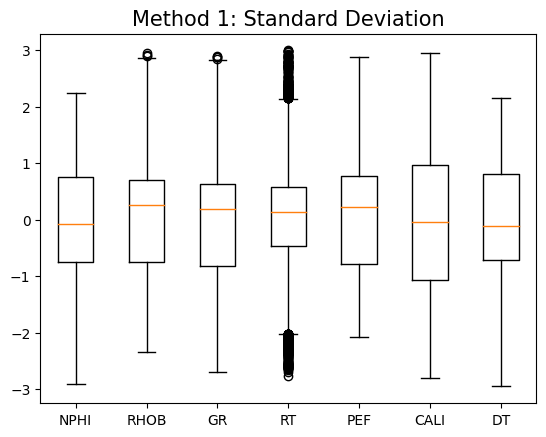

Remaining samples: 24101


In [46]:
train_stdev = train_fonly[np.abs(train_fonly - train_fonly.mean()) <= (3 * train_fonly.std())]

# Delete NaN
train_stdev = train_stdev.dropna()

makeboxplot('Method 1: Standard Deviation',train_stdev)
print('Remaining samples:', len(train_stdev))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


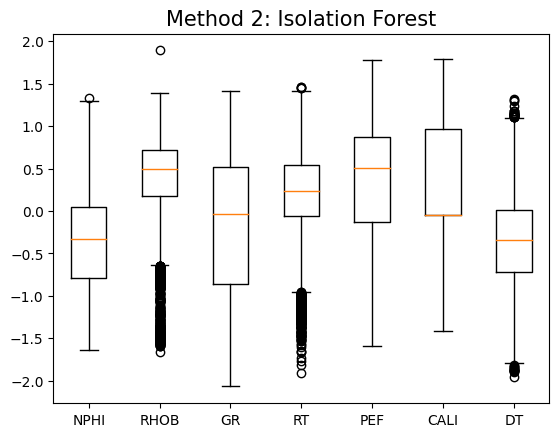

Remaining Samples: 12202


In [47]:
iso = IsolationForest(contamination=0.5)
yhat = iso.fit_predict(train_fonly)

mask = yhat != -1
train_iso = train_fonly[mask]

makeboxplot('Method 2: Isolation Forest',train_iso)
print('Remaining Samples:', len(train_iso))

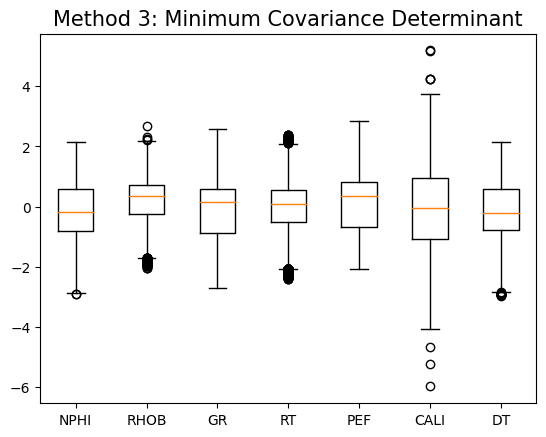

Remaining samples: 21962


In [48]:
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(train_fonly)
mask = yhat != -1
train_ee = train_fonly[mask]

makeboxplot('Method 3: Minimum Covariance Determinant',train_ee)
print('Remaining samples:', len(train_ee))

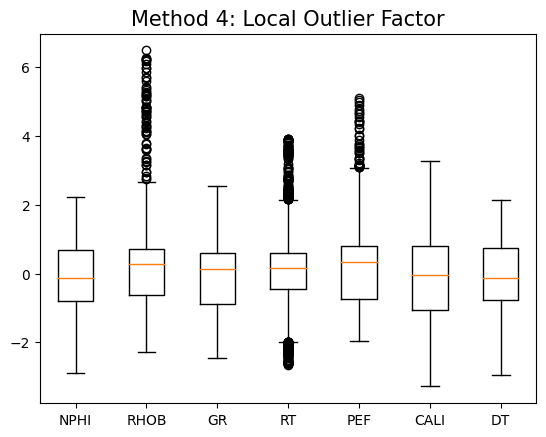

Remaining samples: 17082


In [49]:
lof = LocalOutlierFactor(contamination=0.3)
yhat = lof.fit_predict(train_fonly)
mask = yhat != -1
train_lof = train_fonly[mask]

makeboxplot('Method 4: Local Outlier Factor',train_lof)
print('Remaining samples:', len(train_lof))

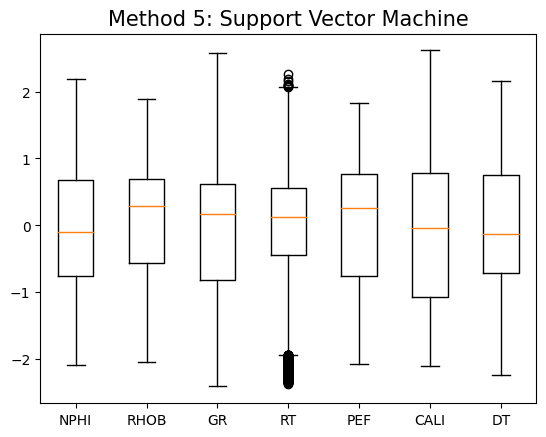

Remaining samples: 21964


In [50]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Method 5: Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

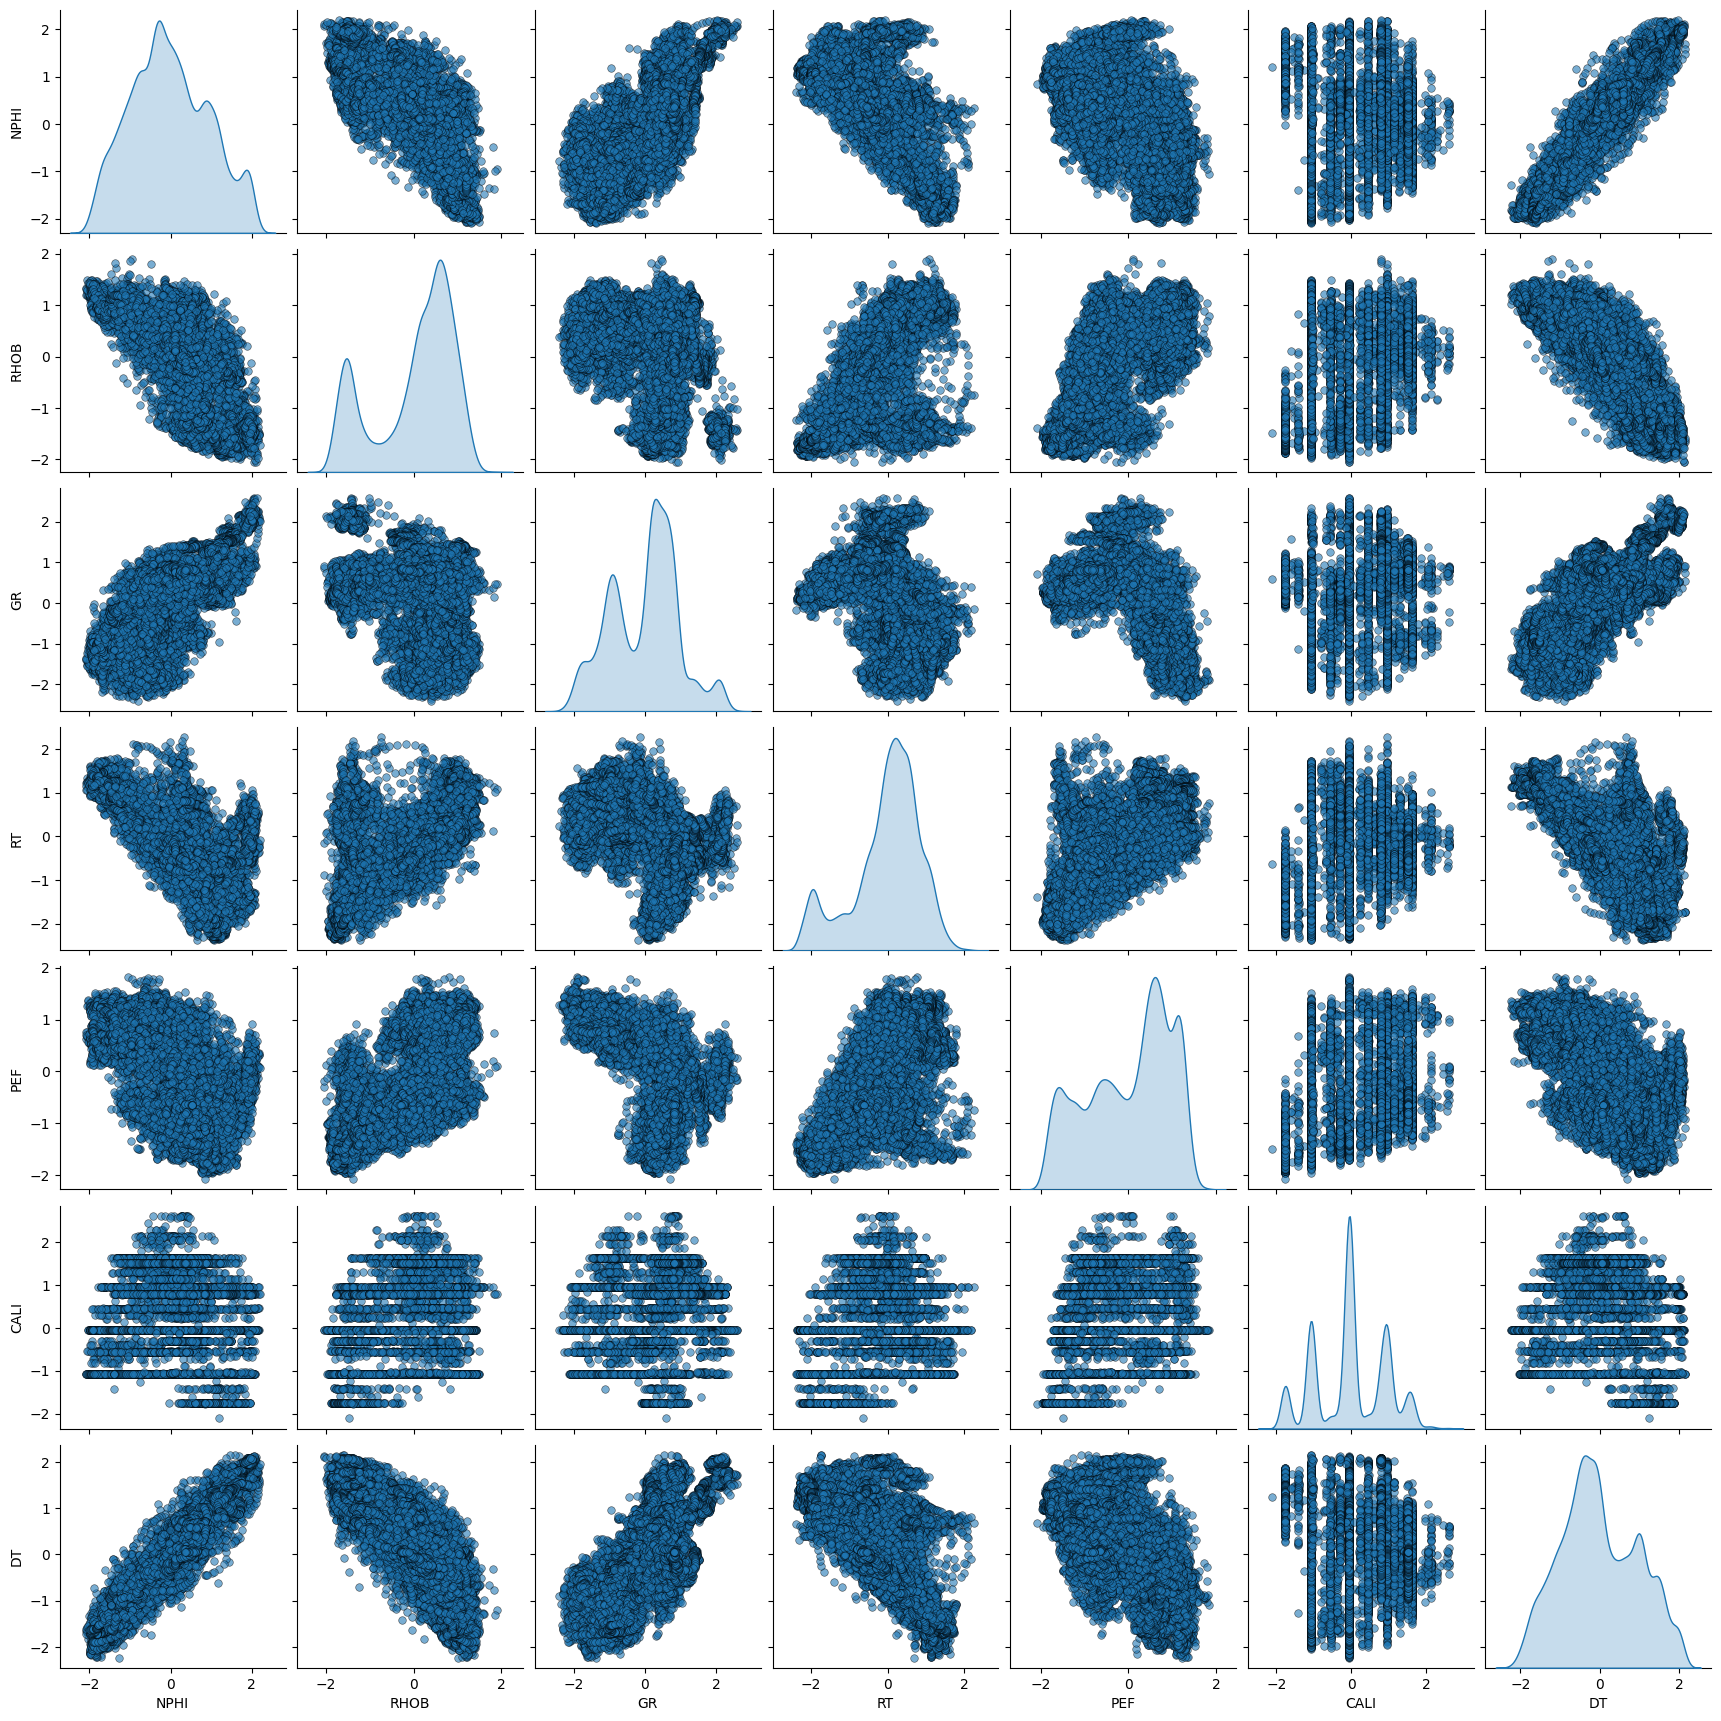

In [51]:
sns.pairplot(train_svm, vars=feature_target,
             diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})